In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
!pip install catboost

# **Saudi dataset**

In [4]:
df=pd.read_csv('../Dataset/New_with_canadian_fwi_updatedRainny.csv')
df.head()


,latitude,longitude,acq_date_converted,month,label,temp_max,rain,wind_speed_ms,wind_speed_kmh,humidity,ffmc,dmc,dc,isi,bui,fwi
0,20.32574,40.89713,15-06-2018,6,1,41.2,0.0,21.9,78.84,41,92.5837,12.5703,25.820,328.8406,12.4766,112.9420
1,17.45982,44.06995,3/1/2019,1,1,29.4,0.0,17.1,61.56,76,85.0477,6.9012,19.996,47.1792,7.4094,28.7687
2,18.39027,42.65908,13-01-2019,1,1,24.9,0.0,24.8,89.28,80,84.0936,6.6402,19.186,167.5354,7.1199,63.9681
3,20.45366,40.47027,14-01-2019,1,1,33.0,0.0,25.9,93.24,85,83.8970,6.6297,20.644,199.2448,7.3547,71.6811
4,20.45205,40.47014,14-01-2019,1,1,33.0,0.0,25.9,93.24,85,83.8970,6.6297,20.644,199.2448,7.3547,71.6811


In [13]:
#معادلات
import requests
from datetime import datetime
import time
import math

# 1. Define the Canadian Fire Weather Index (FWI) System class
class CanadianFWI:
    def __init__(self, temp, rhum, wind, prcp):
        self.h = rhum    # الرطوبة النسبية (%)
        self.t = temp    # درجة الحرارة (C)
        self.w = wind    # سرعة الرياح (km/h)
        self.p = prcp    # هطول الأمطار (mm)

 # Calculate Fine Fuel Moisture Code (FFMC)
    def FFMCcalc(self, ffmc0):
        """حساب مؤشر رطوبة الوقود السطحي"""
        mo = (147.2 * (101.0 - ffmc0)) / (59.5 + ffmc0)  # Equation 1

        if self.p > 0.5:
            rf = self.p - 0.5   # Equation 2
            if mo > 150.0:
                mo = (mo + 42.5 * rf * math.exp(-100.0 / (251.0 - mo)) *
                      (1.0 - math.exp(-6.93 / rf))) + (0.0015 * (mo - 150.0)**2) * math.sqrt(rf)  # 3b
            else:
                mo = mo + 42.5 * rf * math.exp(-100.0 / (251.0 - mo)) * (1.0 - math.exp(-6.93 / rf))  # 3a

            if mo > 250.0:
                mo = 250.0

        ed = (0.942 * (self.h**0.679) + (11.0 * math.exp((self.h - 100.0) / 10.0)) +
              0.18 * (21.1 - self.t) * (1.0 - 1.0 / math.exp(0.115 * self.h)))  # Equation 4


        if mo < ed:
            ew = (0.618 * (self.h**0.753) + (10.0 * math.exp((self.h - 100.0) / 10.0)) +
                  0.18 * (21.1 - self.t) * (1.0 - 1.0 / math.exp(0.115 * self.h)))   # Equation 1


            if mo <= ew:
                kl = (0.424 * (1.0 - ((100.0 - self.h) / 100.0)**1.7) +
                      (0.0694 * math.sqrt(self.w)) * (1.0 - ((100.0 - self.h) / 100.0)**8))  # 7a
                kw = kl * (0.581 * math.exp(0.0365 * self.t))  # 7b
                m = ew - (ew - mo) / (10.0**kw)  # 9
            else:
                m = mo
        elif mo == ed:
            m = mo
        else:
            kl = (0.424 * (1.0 - (self.h / 100.0)**1.7) +
                  (0.0694 * math.sqrt(self.w)) * (1.0 - (self.h / 100.0)**8))  # 6a
            kw = kl * (0.581 * math.exp(0.0365 * self.t))  # 6b
            m = ed + (mo - ed) / (10.0**kw)  # 8

        ffmc = (59.5 * (250.0 - m)) / (147.2 + m)  # 10
        ffmc = max(0.0, min(101.0, ffmc))
        return ffmc
# Calculate Duff Moisture Code (DMC)
    def DMCcalc(self, dmc0, mth):
        """حساب مؤشر رطوبة الطبقة العضوية"""
        el = [6.5, 7.5, 9.0, 12.8, 13.9, 13.9, 12.4, 10.9, 9.4, 8.0, 7.0, 6.0]  # Monthly adjustment factors

        t = self.t
        if t < -1.1:
            t = -1.1

        rk = 1.894 * (t + 1.1) * (100.0 - self.h) * (el[mth-1] * 0.0001)  # 16/17

        if self.p > 1.5:
            ra = self.p
            rw = 0.92 * ra - 1.27  # 11
            wmi = 20.0 + 280.0 / math.exp(0.023 * dmc0)  # 12

            if dmc0 <= 33.0:
                b = 100.0 / (0.5 + 0.3 * dmc0)  # 13a
            elif dmc0 <= 65.0:
                b = 14.0 - 1.3 * math.log(dmc0)  # 13b
            else:
                b = 6.2 * math.log(dmc0) - 17.2  # 13c

            wmr = wmi + (1000 * rw) / (48.77 + b * rw)  # 14
            pr = 43.43 * (5.6348 - math.log(wmr - 20.0))  # 15
        else:
            pr = dmc0

        pr = max(0.0, pr)
        dmc = pr + rk
        dmc = max(1.0, dmc)
        return dmc
  # Calculate Drought Code (DC)
    def DCcalc(self, dc0, mth):
        """حساب مؤشر الجفاف"""
        fl = [-1.6, -1.6, -1.6, 0.9, 3.8, 5.8, 6.4, 5.0, 2.4, 0.4, -1.6, -1.6]  # Monthly adjustment factors

        t = self.t
        if t < -2.8:
            t = -2.8

        pe = (0.36 * (t + 2.8) + fl[mth-1]) / 2  # 22
        pe = max(0.0, pe)

        if self.p > 2.8:
            ra = self.p
            rw = 0.83 * ra - 1.27  # 18
            smi = 800.0 * math.exp(-dc0 / 400.0)  # 19
            dr = dc0 - 400.0 * math.log(1.0 + (3.937 * rw / smi))  # 20/21
            if dr > 0.0:
                dc = dr + pe
            else:
                dc = pe
        else:
            dc = dc0 + pe

        return dc
 # Calculate Initial Spread Index (ISI)
    def ISIcalc(self, ffmc):
        """حساب مؤشر الانتشار الأولي"""
        mo = (147.2 * (101.0 - ffmc)) / (59.5 + ffmc)  # 1
        ff = 19.115 * math.exp(mo * -0.1386) * (1.0 + (mo**5.31) / 49300000.0)  # 25
        isi = ff * math.exp(0.05039 * self.w)  # 26
        return isi
 # Calculate Buildup Index (BUI)
    def BUIcalc(self, dmc, dc):
        """حساب مؤشر تراكم الوقود"""
        if dmc <= 0.4 * dc:
            bui = (0.8 * dc * dmc) / (dmc + 0.4 * dc)  # 27a
        else:
            bui = dmc - (1.0 - 0.8 * dc / (dmc + 0.4 * dc)) * (0.92 + (0.0114 * dmc)**1.7)  # 27b

        bui = max(0.0, bui)
        return bui
 # Calculate Final Fire Weather Index (FWI)
    def FWIcalc(self, isi, bui):
        """حساب المؤشر النهائي للطقس الحارقي"""
        if bui <= 80.0:
            bb = 0.1 * isi * (0.626 * bui**0.809 + 2.0)  # 28a
        else:
            bb = 0.1 * isi * (1000.0 / (25.0 + 108.64 / math.exp(0.023 * bui)))  # 28b

        if bb <= 1.0:
            fwi = bb  # 30a
        else:
            fwi = math.exp(2.72 * (0.434 * math.log(bb))**0.647)  # 30b

        return fwi

In [14]:
print(df.columns.tolist())

['latitude', 'longitude', 'acq_date_converted', 'month', 'label', 'temp_max', 'rain', 'wind_speed_ms', 'wind_speed_kmh', 'humidity', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']


In [15]:
# Convert the date into day, month, and year
df["acq_date"] = pd.to_datetime(df["acq_date_converted"], format="mixed", dayfirst=True)
df["day"] = df["acq_date"].dt.day
df["month"] = df["acq_date"].dt.month
df["year"] = df["acq_date"].dt.year

# Rename columns
df = df.rename(columns={
    "temp_max": "Temperature",
    "humidity": "RH",
    "rain": "Rain",
    "wind_speed_ms": "Ws",
    "label": "Classes"
})

# Select only the important columns-
df = df[[
    "day", "month", "year",
    "Temperature", "RH", "Rain", "Ws",
    "ffmc", "dmc", "dc", "isi", "bui", "fwi",
    "Classes"
]]


In [16]:
df.head()

,day,month,year,Temperature,RH,Rain,Ws,ffmc,dmc,dc,isi,bui,fwi,Classes
0,15,6,2018,41.2,41,0.0,21.9,92.5837,12.5703,25.820,328.8406,12.4766,112.9420,1
1,3,1,2019,29.4,76,0.0,17.1,85.0477,6.9012,19.996,47.1792,7.4094,28.7687,1
2,13,1,2019,24.9,80,0.0,24.8,84.0936,6.6402,19.186,167.5354,7.1199,63.9681,1
3,14,1,2019,33.0,85,0.0,25.9,83.8970,6.6297,20.644,199.2448,7.3547,71.6811,1
4,14,1,2019,33.0,85,0.0,25.9,83.8970,6.6297,20.644,199.2448,7.3547,71.6811,1


In [17]:
df["Classes"] = df["Classes"].map({0: "not fire", 1: "fire"})


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop("Classes", axis=1)
y = df["Classes"]

X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
print(df["Classes"].value_counts())


Classes
not fire    540
fire         73
Name: count, dtype: int64


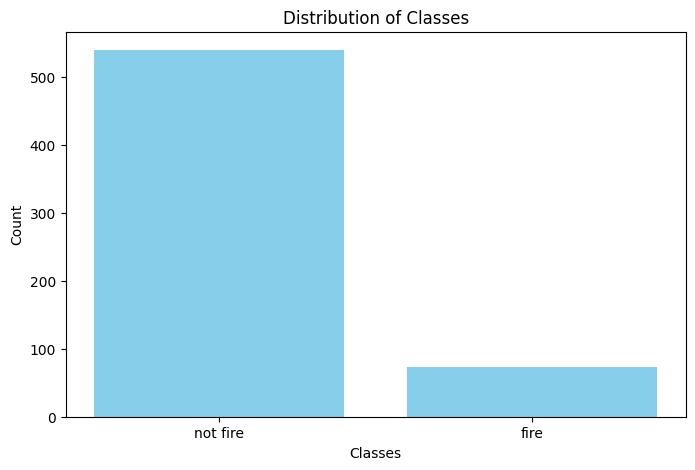

In [ ]:
import matplotlib.pyplot as plt

counts = df['Classes'].value_counts()
# plt for Distribution of Classes
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Distribution of Classes")
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
# Random forest
rf = RandomForestClassifier(random_state=42)

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

# 5 Cross-Validation
best_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_rf = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
f1_fire = f1_score(y_test, y_pred_rf, average='weighted')
print(f" F1 Score: {f1_fire:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Best params: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.9387755102040817
CV Scores: [0.92857143 0.95918367 0.95918367 0.93877551 0.90816327]
Mean CV: 0.9387755102040817
Test Accuracy: 0.9024390243902439
 F1 Score: 0.8952

Classification Report:
               precision    recall  f1-score   support

        fire       0.60      0.43      0.50        14
    not fire       0.93      0.96      0.95       109

    accuracy                           0.90       123
   macro avg       0.76      0.70      0.72       123
weighted avg       0.89      0.90      0.90       123



SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SVM
svm = SVC(probability=True, random_state=42)

# Grid Search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
grid_svm.fit(X_train_scaled, y_train)

print("Best params:", grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

# 5 Cross-Validation
best_svm = grid_svm.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_svm = best_svm.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
f1_fire = f1_score(y_test, y_pred_svm, average='weighted')
print(f"F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.9081632653061223
CV Scores: [0.91836735 0.89795918 0.91836735 0.91836735 0.8877551 ]
Mean CV: 0.9081632653061223
Test Accuracy: 0.8861788617886179
F1 Score: 0.8571

Classification Report:
               precision    recall  f1-score   support

        fire       0.50      0.14      0.22        14
    not fire       0.90      0.98      0.94       109

    accuracy                           0.89       123
   macro avg       0.70      0.56      0.58       123
weighted avg       0.85      0.89      0.86       123



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Grid Search
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
grid_log = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy")
grid_log.fit(X_train_scaled, y_train)

print("Best params:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

# 5 Cross-Validation
best_log = grid_log.best_estimator_
cv_scores = cross_val_score(best_log, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_log = best_log.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_log))
f1_fire = f1_score(y_test, y_pred_log, average='weighted')
print(f" F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))


Best params: {'C': 1, 'penalty': 'l2'}
Best CV Accuracy: 0.8877551020408163
CV Scores: [0.89795918 0.8877551  0.8877551  0.8877551  0.87755102]
Mean CV: 0.8877551020408163
Test Accuracy: 0.8780487804878049
 F1 Score: 0.8286

Classification Report:
               precision    recall  f1-score   support

        fire       0.00      0.00      0.00        14
    not fire       0.89      0.99      0.94       109

    accuracy                           0.88       123
   macro avg       0.44      0.50      0.47       123
weighted avg       0.78      0.88      0.83       123



 XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# XGBoost
xgb = XGBClassifier(
    random_state=42,
    eval_metric="mlogloss"
)

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train, y_train_enc)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

# 5 Cross-Validation
best_xgb = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb, X_train, y_train_enc, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_xgb = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
f1_fire = f1_score(y_test_enc, y_pred_xgb, average='weighted')
print(f"F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV Accuracy: 0.9326530612244899
CV Scores: [0.92857143 0.90816327 0.97959184 0.92857143 0.91836735]
Mean CV: 0.9326530612244899
Test Accuracy: 0.926829268292683
F1 Score: 0.9158

Classification Report:
               precision    recall  f1-score   support

        fire       0.86      0.43      0.57        14
    not fire       0.93      0.99      0.96       109

    accuracy                           0.93       123
   macro avg       0.89      0.71      0.77       123
weighted avg       0.92      0.93      0.92       123



Catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [ ]:
# Catboost
model = CatBoostClassifier(
    verbose=0,
    random_state=42
)
# Grid Search
param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_Cat = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_Cat.fit(X_train, y_train)

print("Best params:",grid_Cat.best_params_)
print("Best CV Accuracy:", grid_Cat.best_score_)

# 5 Cross-Validation
best_Cat = grid_Cat.best_estimator_
cv_scores = cross_val_score(best_Cat, X_train, y_train, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_catboost = best_Cat.predict(X_test)

print("\n Accuracy:", round(accuracy_score(y_test, y_pred_catboost), 4))
f1_fire = f1_score(y_test, y_pred_catboost, average='weighted')
print(f" F1 Score: {f1_fire:.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred_catboost))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best CV Accuracy: 0.936734693877551
CV Scores: [0.91836735 0.93877551 0.96938776 0.93877551 0.91836735]
Mean CV: 0.936734693877551

 Accuracy: 0.9024
 F1 Score: 0.8904

 Classification Report:
               precision    recall  f1-score   support

        fire       0.62      0.36      0.45        14
    not fire       0.92      0.97      0.95       109

    accuracy                           0.90       123
   macro avg       0.77      0.66      0.70       123
weighted avg       0.89      0.90      0.89       123



Stacking

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
rf = RandomForestClassifier(random_state=42)
# Grid Search for rf
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train_enc)
print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Accuracy:", round(rf_grid.best_score_, 4))
best_RF = rf_grid.best_estimator_


# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

#Scaling
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", xgb)
])
# Grid Search for xgboost
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train, y_train_enc)
print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV Accuracy:", round(xgb_grid.best_score_, 4))
best_XGB = xgb_grid.best_estimator_


#  CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
# Grid Search for catboost
cat_params = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train, y_train_enc)
print("Best Cat Params:", cat_grid.best_params_)
print("Best Cat CV Accuracy:", round(cat_grid.best_score_, 4))
best_Cat = cat_grid.best_estimator_


# --- Stacking Classifier ---
estimators = [
    ("rf", best_RF),
    ("xgb", best_XGB),
    ("cat", best_Cat)
]
# Stack model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1
)

# 5 Cross Validation
scores = cross_val_score(stack_model, X_train, y_train_enc, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

stack_model.fit(X_train, y_train_enc)

# Test evaluation
y_pred_stack = stack_model.predict(X_test)

print(" Stacking Test Accuracy:", accuracy_score(y_test_enc, y_pred_stack))
f1_fire = f1_score(y_test_enc, y_pred_stack, average='weighted')
print(f" F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_stack, target_names=le.classes_))


Best RF Params: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RF CV Accuracy: 0.9286


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:39:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Best XGB CV Accuracy: 0.9306
Best Cat Params: {'depth': 8, 'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best Cat CV Accuracy: 0.9347
Stacking CV Accuracy: 0.9347 ± 0.0153
 Stacking Test Accuracy: 0.9186991869918699
 F1 Score: 0.9039

Classification Report:
               precision    recall  f1-score   support

        fire       0.83      0.36      0.50        14
    not fire       0.92      0.99      0.96       109

    accuracy                           0.92       123
   macro avg       0.88      0.67      0.73       123
weighted avg       0.91      0.92      0.90       123



## **ML model with oversampler for saudi dataset**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

from collections import Counter
print("Class distribution after RandomOverSampler:", Counter(y_train_res))


Class distribution after RandomOverSampler: Counter({'not fire': 431, 'fire': 431})


Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)

print("Best params:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

# 5 Cross-Validation
best_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_rf = best_rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
f1_fire = f1_score(y_test, y_pred_rf, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Best params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.9547788681274365
CV Scores: [0.95375723 0.93641618 0.96511628 0.97093023 0.94767442]
Mean CV: 0.9547788681274365
Test Accuracy: 0.8536585365853658
 Overall F1 Score: 0.8671

Classification Report:
               precision    recall  f1-score   support

        fire       0.41      0.64      0.50        14
    not fire       0.95      0.88      0.91       109

    accuracy                           0.85       123
   macro avg       0.68      0.76      0.71       123
weighted avg       0.89      0.85      0.87       123



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Grid Search
param_grid = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"]}
grid_log = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy")
grid_log.fit(X_train_res_scaled, y_train_res)

print("Best params:", grid_log.best_params_)
print("Best CV Accuracy:", grid_log.best_score_)

# 5 Cross-Validation
best_log = grid_log.best_estimator_
cv_scores = cross_val_score(best_log, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_log = best_log.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_log))
f1_fire = f1_score(y_test, y_pred_log, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Best params: {'C': 10, 'penalty': 'l2'}
Best CV Accuracy: 0.6983667159564457
CV Scores: [0.67052023 0.73410405 0.6744186  0.69186047 0.72093023]
Mean CV: 0.6983667159564457
Test Accuracy: 0.6747967479674797
 Overall F1 Score: 0.7311

Classification Report:
               precision    recall  f1-score   support

        fire       0.17      0.50      0.26        14
    not fire       0.92      0.70      0.79       109

    accuracy                           0.67       123
   macro avg       0.55      0.60      0.53       123
weighted avg       0.83      0.67      0.73       123



SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SVM
svm = SVC(probability=True, random_state=42)

# Grid Search
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
grid_svm.fit(X_train_res_scaled, y_train_res)

print("Best params:", grid_svm.best_params_)
print("Best CV Accuracy:", grid_svm.best_score_)

# 5 Cross-Validation
best_svm = grid_svm.best_estimator_
cv_scores = cross_val_score(best_svm, X_train_res_scaled, y_train_res, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_svm = best_svm.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
f1_fire = f1_score(y_test, y_pred_svm, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.924633687323565
CV Scores: [0.89595376 0.91907514 0.9127907  0.93604651 0.95930233]
Mean CV: 0.924633687323565
Test Accuracy: 0.8780487804878049
 Overall F1 Score: 0.8882

Classification Report:
               precision    recall  f1-score   support

        fire       0.48      0.71      0.57        14
    not fire       0.96      0.90      0.93       109

    accuracy                           0.88       123
   macro avg       0.72      0.81      0.75       123
weighted avg       0.91      0.88      0.89       123



XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

In [ ]:
# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")

# Grid Search
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train_res, y_train_res_enc)

print("Best params:", grid_xgb.best_params_)
print("Best CV Accuracy:", grid_xgb.best_score_)

# 5 Cross-Validation
best_xgb = grid_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb, X_train_res, y_train_res_enc, cv=5, scoring="accuracy")
print("CV Scores:", cv_scores)
print("Mean CV:", cv_scores.mean())

# Test evaluation
y_pred_xgb = best_xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test_enc, y_pred_xgb))
f1_fire = f1_score(y_test_enc, y_pred_xgb, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_xgb))


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV Accuracy: 0.9791571447775238
CV Scores: [0.97687861 0.94797688 0.98837209 0.99418605 0.98837209]
Mean CV: 0.9791571447775238
Test Accuracy: 0.9024390243902439
 Overall F1 Score: 0.8991

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.50      0.54        14
           1       0.94      0.95      0.95       109

    accuracy                           0.90       123
   macro avg       0.76      0.73      0.74       123
weighted avg       0.90      0.90      0.90       123



catboost

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report,f1_score
from catboost import CatBoostClassifier

In [ ]:
# Catboost
catboost = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# Grid Search
param_grid = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

grid_cat = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_cat.fit(X_train_res, y_train_res)

print(" Best Parameters:", grid_cat.best_params_)
print(" Best CV Accuracy:", grid_cat.best_score_)


# 5 Cross-Validation
best_cat = grid_cat.best_estimator_
cv_scores = cross_val_score(best_cat, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("\n Cross-Validation Scores:", cv_scores)
print(" Mean CV Accuracy:", cv_scores.mean())

# Test evaluation
y_pred = best_cat.predict(X_test)

print("\n Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
f1_fire = f1_score(y_test, y_pred, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
 Best Parameters: {'depth': 6, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
 Best CV Accuracy: 0.9826387955370345

 Cross-Validation Scores: [0.98265896 0.94797688 1.         1.         0.98255814]
 Mean CV Accuracy: 0.9826387955370345

 Test Accuracy: 0.9106
 Overall F1 Score: 0.9091

 Classification Report:
               precision    recall  f1-score   support

        fire       0.62      0.57      0.59        14
    not fire       0.95      0.95      0.95       109

    accuracy                           0.91       123
   macro avg       0.78      0.76      0.77       123
weighted avg       0.91      0.91      0.91       123



Stacking

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_train_res_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

In [ ]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
rf = RandomForestClassifier(random_state=42)
#Grid Search for rf
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res_enc)
print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Accuracy:", round(rf_grid.best_score_, 4))
best_RF = rf_grid.best_estimator_


# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

#Scaling
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", xgb)
])
#Grid  for xgboost
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train_res, y_train_res_enc)
print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB CV Accuracy:", round(xgb_grid.best_score_, 4))
best_XGB = xgb_grid.best_estimator_


#  CatBoost
cat = CatBoostClassifier(verbose=0, random_state=42)
# Grid Search for catboost
cat_params = {
    'iterations': [200, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}
cat_grid = GridSearchCV(cat, cat_params, cv=cv, scoring="accuracy", n_jobs=-1)
cat_grid.fit(X_train_res, y_train_res_enc)
print("Best Cat Params:", cat_grid.best_params_)
print("Best Cat CV Accuracy:", round(cat_grid.best_score_, 4))
best_Cat = cat_grid.best_estimator_


# --- Stacking Classifier ---
estimators = [
    ("rf", best_RF),
    ("xgb", best_XGB),
    ("cat", best_Cat)
]
# Stack model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1
)

# 5 Cross Validation
scores = cross_val_score(stack_model, X_train_res, y_train_res_enc, cv=cv, scoring="accuracy")
print("Stacking CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

stack_model.fit(X_train_res, y_train_res_enc)

# Test evaluation
y_pred_stack = stack_model.predict(X_test)

print("Stacking Test Accuracy:", accuracy_score(y_test_enc, y_pred_stack))
f1_fire = f1_score(y_test_enc, y_pred_stack, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred_stack, target_names=le.classes_))


Best RF Params: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV Accuracy: 0.9513


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:04:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best XGB CV Accuracy: 0.978
Best Cat Params: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best Cat CV Accuracy: 0.9826
Stacking CV Accuracy: 0.9838 ± 0.0106
Stacking Test Accuracy: 0.9349593495934959
 Overall F1 Score: 0.9301

Classification Report:
               precision    recall  f1-score   support

        fire       0.80      0.57      0.67        14
    not fire       0.95      0.98      0.96       109

    accuracy                           0.93       123
   macro avg       0.87      0.78      0.82       123
weighted avg       0.93      0.93      0.93       123



# **DL model for Saudi dataset**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
#LSTM

# Reshape data to 3D format (samples, timesteps, features)
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),     # to prevent overfitting
    Dense(1, activation="sigmoid")
])

# compile
model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc,
    validation_data=(X_test_lstm, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_enc, verbose=0)
print("LSTM Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred)
print("Confusion Matrix:")
print(cm)

f1_fire = f1_score(y_test_enc, y_pred, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6007 - loss: 0.6729 - val_accuracy: 0.8862 - val_loss: 0.3777
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8710 - loss: 0.4028 - val_accuracy: 0.8862 - val_loss: 0.3682
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8754 - loss: 0.3846 - val_accuracy: 0.8862 - val_loss: 0.3615
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9030 - loss: 0.3613 - val_accuracy: 0.8862 - val_loss: 0.3583
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8680 - loss: 0.4420 - val_accuracy: 0.8862 - val_loss: 0.3630
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9013 - loss: 0.3607 - val_accuracy: 0.8862 - val_loss: 0.3633
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8564 - loss: 0.4570 - val_accuracy: 0.8862 - val_loss: 0.3595
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9089 - loss: 0.3247 - val_accuracy: 0.8862 - val_loss

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
#CNND1

# Reshape data to 3D format (samples, timesteps, features)
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu",
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5), # to prevent overfitting
    Dense(1, activation="sigmoid")
])

# compile
model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_cnn.evaluate(X_test_cnn, y_test_enc, verbose=0)
print(" CNN1D Test Accuracy:", acc)

y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_cnn)
print("Confusion Matrix:")
print(cm)
f1_fire = f1_score(y_test_enc, y_pred_cnn, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_cnn))

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.7062 - loss: 58.6855 - val_accuracy: 0.8862 - val_loss: 18.3969
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7811 - loss: 30.7986 - val_accuracy: 0.8862 - val_loss: 15.8482
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7684 - loss: 39.8225 - val_accuracy: 0.8862 - val_loss: 10.3588
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7930 - loss: 19.7143 - val_accuracy: 0.8862 - val_loss: 3.1303
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7711 - loss: 12.7750 - val_accuracy: 0.8862 - val_loss: 2.0826
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7710 - loss: 9.4691 - val_accuracy: 0.8862 - val_loss: 0.8052
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8044 - loss: 5.4103 - val_accuracy: 0.8862 - val_loss: 0.5168
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 2.5041 - val_accuracy: 0.8862 - val_loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,f1_score
import numpy as np

In [ ]:
#MLP

# Prepare data by convert to numpy arrays
X_train_mlp = X_train.values
X_test_mlp = X_test.values

model_mlp = Sequential([
    Input(shape=(X_train_mlp.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.3),  # to prevent overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# compile
model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_mlp = model_mlp.fit(
    X_train_mlp, y_train_enc,
    validation_data=(X_test_mlp, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_mlp.evaluate(X_test_mlp, y_test_enc, verbose=0)
print(" MLP Test Accuracy:", acc)

y_pred_probs = model_mlp.predict(X_test_mlp)
y_pred_mlp = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_mlp)
print("Confusion Matrix:")
print(cm)

f1_fire = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_mlp))

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7804 - loss: 47.1737 - val_accuracy: 0.8862 - val_loss: 12.9988
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7614 - loss: 22.3742 - val_accuracy: 0.8862 - val_loss: 9.5119
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7525 - loss: 14.3849 - val_accuracy: 0.8862 - val_loss: 7.7975
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7956 - loss: 10.9169 - val_accuracy: 0.8862 - val_loss: 3.3219
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7740 - loss: 13.8902 - val_accuracy: 0.8862 - val_loss: 3.2644
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7806 - loss: 8.9013 - val_accuracy: 0.8862 - val_loss: 2.4145
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8197 - loss: 5.6518 - val_accuracy: 0.7967 - val_loss: 1.4810
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7394 - loss: 6.7747 - val_accuracy: 0.8862 - v

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[  0  14]
 [  0 109]]
 Overall F1 Score: 0.8327

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.89      1.00      0.94       109

    accuracy                           0.89       123
   macro avg       0.44      0.50      0.47       123
weighted avg       0.79      0.89      0.83       123



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNN2D

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# CNN2D

# Reshape for data to 4D (samples, rows, cols, channels)
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)


model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),  # to prevent overfitting

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile
model_cnn2d.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_enc,
    validation_data=(X_test_cnn2d, y_test_enc),
    epochs=70,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Test evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_enc, verbose=0)
print("CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_cnn2 = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_cnn2)
print("Confusion Matrix:")
print(cm)
f1_fire = f1_score(y_test_enc, y_pred_cnn2, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_cnn2))

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6588 - loss: 0.7163 - val_accuracy: 0.8862 - val_loss: 0.4743
Epoch 2/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8778 - loss: 0.5163 - val_accuracy: 0.8862 - val_loss: 0.4578
Epoch 3/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8826 - loss: 0.4989 - val_accuracy: 0.8862 - val_loss: 0.4550
Epoch 4/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8774 - loss: 0.4407 - val_accuracy: 0.8862 - val_loss: 0.4419
Epoch 5/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8528 - loss: 0.5143 - val_accuracy: 0.8862 - val_loss: 0.4369
Epoch 6/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8560 - loss: 0.4750 - val_accuracy: 0.8862 - val_loss: 0.4308
Epoch 7/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8845 - loss: 0.4396 - val_accuracy: 0.8862 - val_loss: 0.4307
Epoch 8/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8842 - loss: 0.4013 - val_accuracy: 0.8862 - val_loss: 0.4254
E

## **DL with oversampler for Saudi dataset**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

from collections import Counter
print("Class distribution after RandomOverSampler:", Counter(y_train_res))


Class distribution after RandomOverSampler: Counter({'not fire': 431, 'fire': 431})


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
#LSTM

# Reshape data to 3D format (samples, timesteps, features)
X_train_lstm = X_train_res.values.reshape((X_train_res.shape[0], X_train_res.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         kernel_regularizer=regularizers.l2(0.001), return_sequences=False),
    Dropout(0.5),     # to prevent overfitting
    Dense(1, activation="sigmoid")
])

# compile
model_lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_enc,
    validation_data=(X_test_lstm, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_enc, verbose=0)
print("LSTM Test Accuracy:", acc)

y_pred_probs = model_lstm.predict(X_test_lstm)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred)
print("Confusion Matrix:")
print(cm)

f1_fire = f1_score(y_test_enc, y_pred, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred))

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5222 - loss: 0.7339 - val_accuracy: 0.3171 - val_loss: 0.7173
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5574 - loss: 0.6844 - val_accuracy: 0.3089 - val_loss: 0.7393
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5303 - loss: 0.6938 - val_accuracy: 0.3821 - val_loss: 0.7017
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5235 - loss: 0.6994 - val_accuracy: 0.3171 - val_loss: 0.7483
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5921 - loss: 0.6674 - val_accuracy: 0.5935 - val_loss: 0.6372
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5727 - loss: 0.6726 - val_accuracy: 0.3008 - val_loss: 0.8029
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5802 - loss: 0.6580 - val_accuracy: 0.3821 - val_loss: 0.7905
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6260 - loss: 0.6368 - val_accuracy: 0.4634 - val_loss: 0.7720
Ep

CNN1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
#CNND1

# Reshape data to 3D format (samples, timesteps, features)
X_train_cnn = X_train_res.values.reshape((X_train_res.shape[0], X_train_res.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu",
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),  # to prevent overfitting
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_test_cnn, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_cnn.evaluate(X_test_cnn, y_test_enc, verbose=0)
print(" CNN1D Test Accuracy:", acc)

y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_cnn)
print("Confusion Matrix:")
print(cm)
f1_fire = f1_score(y_test_enc, y_pred_cnn, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_cnn))

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4841 - loss: 105.1125 - val_accuracy: 0.2195 - val_loss: 4.2542
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5024 - loss: 31.8486 - val_accuracy: 0.2358 - val_loss: 1.4184
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5485 - loss: 11.4386 - val_accuracy: 0.2033 - val_loss: 0.7554
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5155 - loss: 6.4179 - val_accuracy: 0.1951 - val_loss: 0.7405
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5259 - loss: 2.6197 - val_accuracy: 0.1626 - val_loss: 0.7507
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5547 - loss: 1.4894 - val_accuracy: 0.1626 - val_loss: 0.7578
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5202 - loss: 1.2834 - val_accuracy: 0.1626 - val_loss: 0.7720
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5205 - loss: 1.4967 - val_accuracy: 0.1626 - val_loss: 0.769

MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
#MLP

# Prepare data by convert to numpy arrays
X_train_mlp = X_train_res.values
X_test_mlp = X_test.values

model_mlp = Sequential([
    Input(shape=(X_train_mlp.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.3),  # to prevent overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# compile
model_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Model Training
history_mlp = model_mlp.fit(
    X_train_mlp, y_train_enc,
    validation_data=(X_test_mlp, y_test_enc),
    epochs=50, batch_size=16, verbose=1,
    callbacks=[early_stop]
)

# Test evaluation
loss, acc = model_mlp.evaluate(X_test_mlp, y_test_enc, verbose=0)
print(" MLP Test Accuracy:", acc)

y_pred_probs = model_mlp.predict(X_test_mlp)
y_pred_mlp = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_mlp)
print("Confusion Matrix:")
print(cm)

f1_fire = f1_score(y_test_enc, y_pred_mlp, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_mlp))

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5219 - loss: 71.7423 - val_accuracy: 0.8862 - val_loss: 4.2500
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5179 - loss: 38.8781 - val_accuracy: 0.2764 - val_loss: 8.0532
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5190 - loss: 23.1886 - val_accuracy: 0.8862 - val_loss: 0.7324
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5134 - loss: 13.4546 - val_accuracy: 0.8699 - val_loss: 0.5555
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4957 - loss: 9.8403 - val_accuracy: 0.2846 - val_loss: 1.9299
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5135 - loss: 6.3970 - val_accuracy: 0.2439 - val_loss: 1.1448
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4816 - loss: 3.5838 - val_accuracy: 0.2195 - val_loss: 0.8590
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4986 - loss: 3.0534 - val_accuracy: 0.3171 - val_

CNN2D

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# CNN2D

# Reshape for data to 4D (samples, rows, cols, channels)
X_train_cnn2d = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1, 1)
X_test_cnn2d = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1, 1)


model_cnn2d = Sequential([
    Conv2D(filters=32, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(X_train_cnn2d.shape[1], X_train_cnn2d.shape[2], 1)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),  # to prevent overfitting

    Conv2D(filters=64, kernel_size=(3,1), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2,1)),
    Dropout(0.5),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile
model_cnn2d.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Training
history_cnn2d = model_cnn2d.fit(
    X_train_cnn2d, y_train_enc,
    validation_data=(X_test_cnn2d, y_test_enc),
    epochs=70,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Test evaluation
loss, acc = model_cnn2d.evaluate(X_test_cnn2d, y_test_enc, verbose=0)
print("CNN2D Test Accuracy:", acc)

y_pred_probs = model_cnn2d.predict(X_test_cnn2d)
y_pred_cnn2 = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test_enc, y_pred_cnn2)
print("Confusion Matrix:")
print(cm)
f1_fire = f1_score(y_test_enc, y_pred_cnn2, average='weighted')
print(f" Overall F1 Score: {f1_fire:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_cnn2))

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.5249 - loss: 0.8089 - val_accuracy: 0.8699 - val_loss: 0.7268
Epoch 2/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5282 - loss: 0.7843 - val_accuracy: 0.7642 - val_loss: 0.7349
Epoch 3/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 0.7655 - val_accuracy: 0.7236 - val_loss: 0.7256
Epoch 4/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5927 - loss: 0.7424 - val_accuracy: 0.7724 - val_loss: 0.6858
Epoch 5/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.7194 - val_accuracy: 0.7480 - val_loss: 0.7041
Epoch 6/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6558 - loss: 0.7135 - val_accuracy: 0.7073 - val_loss: 0.6873
Epoch 7/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6958 - loss: 0.6706 - val_accuracy: 0.8049 - val_loss: 0.5940
Epoch 8/70
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6742 - loss: 0.6856 - val_accuracy: 0.7073 - val_loss: 0.6634
Ep

# **Combined dataset (Saudi + Algerian)**

In [20]:
import pandas as pd

df1 = pd.read_csv('Algerian_forest_fires_dataset_CLEANED.csv')
df1.head()


,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [24]:
# df1 =algerian  df= saudi

# Unifying column names in the first and second datasets
df1.rename(columns={
    "ffmc": "FFMC", "dmc": "DMC", "dc": "DC",
    "isi": "ISI", "bui": "BUI", "fwi": "FWI"
}, inplace=True)

df.rename(columns={
    "ffmc": "FFMC", "dmc": "DMC", "dc": "DC",
    "isi": "ISI", "bui": "BUI", "fwi": "FWI"
}, inplace=True)

# Ensure same column order
common_cols = ['day','month','year','Temperature','RH','Ws','Rain',
               'FFMC','DMC','DC','ISI','BUI','FWI','Classes']
df1 = df1[common_cols]
df = df[common_cols]

# Merge the two datasets
df_all = pd.concat([df1, df], ignore_index=True)
df_all.to_csv("merged_fire_data.csv", index=False)
print(" num of row :", len(df_all))

print("Combined dataset shape:", df_all.shape)
print("Class distribution:\n", df_all["Classes"].value_counts())

 num of row : 856
Combined dataset shape: (856, 14)
Class distribution:
 Classes
not fire         542
fire             131
not fire         101
fire              77
fire               2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64
